# Imports

In [2]:
# os
import os

# Numpy
import numpy as np

# Shapely
import shapely
from shapely.geometry import *
from shapely.affinity import *

# Matplotlib
import matplotlib.path
import matplotlib.patches
from matplotlib import pyplot as plt

# Helper functions to draw shapely shapes in matplotlib

Adapted from https://sgillies.net/2010/04/06/painting-punctured-polygons-with-matplotlib.html

In [3]:
def ring_coding(ob):
    '''
        The codes will be all "LINETO" commands, except for "MOVETO"s at the
        beginning of each subpath
    '''
    n = len(ob.coords)
    codes = np.ones(n, dtype = matplotlib.path.Path.code_type) * matplotlib.path.Path.LINETO
    codes[0] = matplotlib.path.Path.MOVETO
    return codes

def pathify(polygon):
    '''
        Convert coordinates to path vertices. Objects produced by Shapely's
        analytic methods have the proper coordinate order, no need to sort.
    '''
    vertices = np.concatenate([np.asarray(polygon.exterior)] + [np.asarray(r) for r in polygon.interiors])
    codes = np.concatenate([ring_coding(polygon.exterior)] + [ring_coding(r) for r in polygon.interiors])
    return matplotlib.path.Path(vertices, codes)

def shape2patches(shape):
    '''
        Convert a shapely shape to a list of matplotlib patches
    '''
    
    if type(shape) == shapely.geometry.MultiPolygon:
        polygons = list(shape)
    else:
        polygons = [shape]
        
    patches = []
    for i, polygon in enumerate(polygons):
        patches.append(matplotlib.patches.PathPatch(pathify(polygon)))
    
    return patches

# "Create Shape" function

It works by starting with a square and repeatedly adding or subtracting another shape from it. Shapes include:
- Rotated rectangle
- Circle

In [4]:
def create_shape(n = 4):

    # Start with a square 'canvas'
    polygon = Polygon([[0, 0], [0, 1], [1, 1], [1, 0]])
    
    for i in range(n):
        
        # Sample shape position
        x, y = np.random.randint(0, 3, 2) / 2
        # Sample shape dimensions
        w, h = np.random.randint(1, 3, 2) / 4
        
        # Choose between rectangle and circle
        if np.random.rand() < .5:
            
            # Define rectangle
            r = 45 * np.random.randint(-2, 2)
            aux = Polygon([[-1, -1], [-1, 1], [1, 1], [1, -1]])
            aux = translate(aux, x, y)
            aux = scale(aux, w, h)
            aux = rotate(aux, r)
            
            # Choose between adding or subtracting
            if np.random.rand() < 1:
                polygon = polygon.difference(aux)
            else:
                polygon = polygon.union(aux)
                
        else:
            
            # Define circle
            aux = Point((x, y)).buffer(w)
            
            # Choose between adding or subtracting
            if np.random.rand() < .75:
                polygon = polygon.difference(aux)
            else:
                polygon = polygon.union(scale(aux, .5, .5))
        
    return polygon

# Create square mosaic

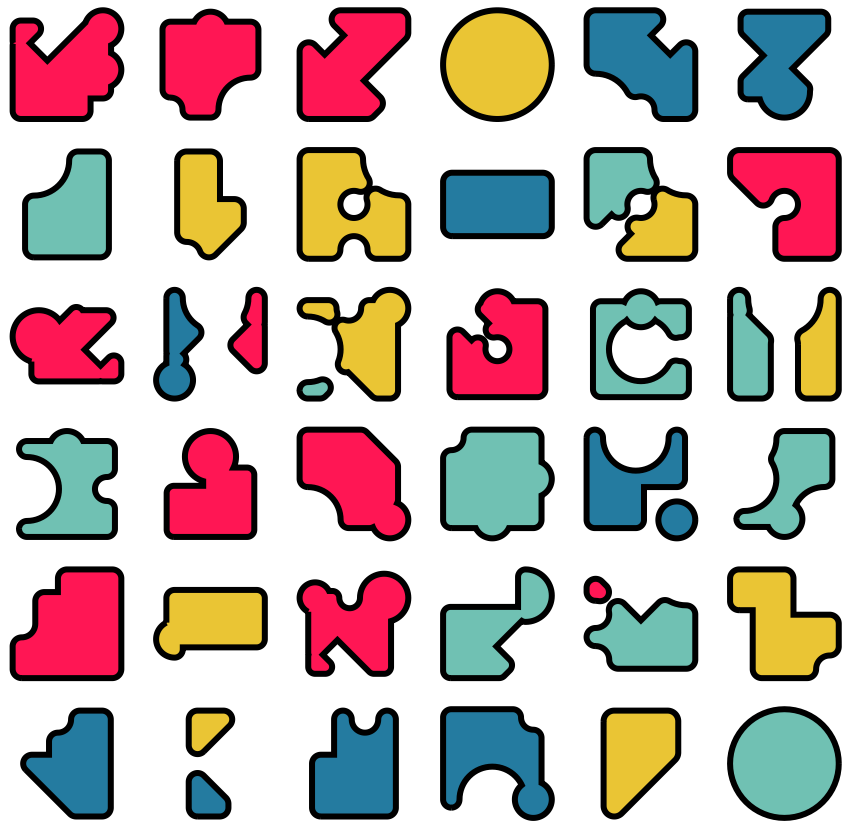

In [5]:
palette = ['#247BA0', '#EAC534', '#FF1654', '#70C1B3']

fig, axes = plt.subplots(6, 6, figsize = (15, 15))
axes = np.concatenate(axes)

for i, ax in enumerate(axes):
    while True:
        try:
            ax.axis('off')
            ax.axis('equal')
            
            shape = create_shape(4).buffer(.1)

            for patch in shape2patches(shape):
                patch.set_lw(6)
                patch.set_fc(np.random.choice(palette))
                patch.set_fill(True)
                ax.add_patch(patch)

            ax.autoscale()
            break
        except:
            pass

# Create "space filling" mosaic

## Clone qnzhou's 'Mosaic' repo

In [8]:
!git clone https://github.com/qnzhou/Mosaic

Cloning into 'Mosaic'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 39 (delta 4), reused 3 (delta 1), pack-reused 24
Unpacking objects: 100% (39/39), 15.36 KiB | 296.00 KiB/s, done.


# Create and save 'n' shapes

In [10]:
if not os.path.isdir('shapes'):
    !mkdir shapes

# Define palette
palette = ['#247BA0', '#EAC534', '#FF1654', '#70C1B3']

n = 500

for i in range(n):
    
    # Wrapping in try-catch since create_shape may create empty polygons
    try:
        fig, ax = plt.subplots(figsize = (5, 5))
        ax.axis('off')
        ax.axis('equal')

        shape = create_shape(np.random.randint(4, 6)).buffer(.1)
        shape = rotate(shape, np.random.choice([-45, 0, 45]))

        for patch in shape2patches(shape):
            patch.set_lw(6)
            patch.set_fc(np.random.choice(palette))
            patch.set_fill(True)
            ax.add_patch(patch)

        ax.autoscale()

        plt.savefig(f'shapes/{i}.png', format = 'png', transparent = True)
        plt.close('all')
    except:
        pass

## Use qnzhou tool to generate mosaic

In [13]:
! ./Mosaic/generate_mosaic.py -W 800 -H 800 shapes figures/mosaic.png

100 images are packed so far!
200 images are packed so far!
A total of 252 images are packed!


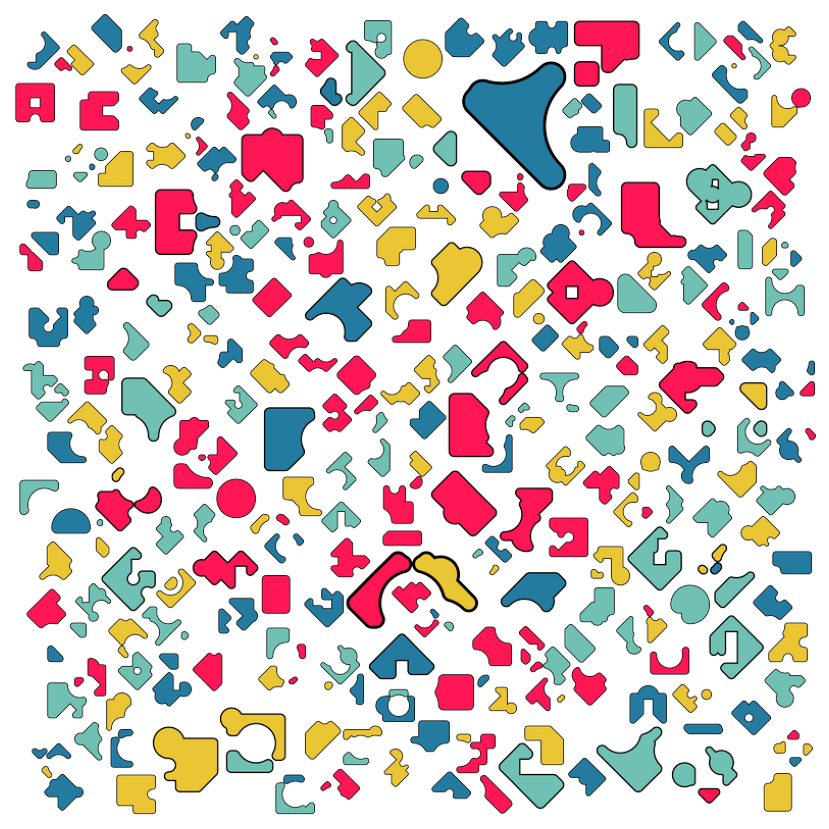

In [14]:
fig, ax = plt.subplots(figsize = (15, 15))
ax.axis('off')
ax.imshow(plt.imread('figures/mosaic.png'))
plt.show()